# AD12 - Leitura paralela de dados com o HDFS

O objetivo é demonstrar o emprego da leitura paralela de dados utilizando o Hadoop Distributed File System (HDFS), e observar a aceleração quando se lê os dados em paralelo na medida que os arquivos estão replicados em diferentes nós de dados. Para realizar este experimento, o professor instalou previamente o HDFS em duas máquinas do PCAD, sendo o nó `cei1` o servidor de nomes e de dados, enquanto o nó `cei2` é um servidor de dados.

Para realizar este experimento, o professor lançará este notebook na máquina `cei1` (143.54.48.109) com o comando:

```{bash}
jupyter notebook --port=8787 --ip=143.54.48.109
```

Empregaremos a porta `8787` por ela já estar liberada no firewall da gppd-hpc.inf.ufrgs.br e adequadamente redirecionada para a máquina `cei1`.

## Configuração HDFS e importação dos dados

### Gerar uma tabela com 6.8 GBytes

Vamos gerar uma tabela com duas colunas e 800 milhões de valores aleatórios distribuídos de maneira uniforme entre 0 e 1. Empregamos `np.random.random` para em seguidar fazer o `reshape` antes de importar para `dask.dataframe` com o método `from_array`. Reparticionamos para 2 pois faremos o experimento com 2 threads.

In [ ]:
import numpy as np
import dask
import dask.dataframe as dd
df = dd.from_array(np.random.random(800000000).reshape((-1,2)),
                   columns=["x", "y"]) \
    .repartition(2)
df

,x,y
npartitions=2,,
0,float64,float64
200000000,...,...
399999999,...,...


### Importação dos dados no Hadoop Distributed File System (HDFS)

Podemos antecipar a conexão com o HDFS utilizando `pyarrow`.

In [ ]:
import pyarrow
from pyarrow import fs
hdfs = fs.HadoopFileSystem("hdfs://cei1.inf.ufrgs.br", 9000)

2022-10-24 17:33:35,296 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Ou podemos pular o passo interior e diretamente salvar os dados no HDFS.

In [ ]:
URL = 'hdfs://schnorr@cei1.inf.ufrgs.br:9000/user/schnorr/save.parquet'
df.to_parquet(URL)

/home/users/schnorr/.localPython-3.10.7/lib/python3.10/site-packages/fsspec/implementations/hdfs.py:83: FutureWarning: pyarrow.hdfs.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  self.client = HadoopFileSystem(


# Instanciando o cluster

Vamos agora instanciar o `dask-scheduler` na máquina `cei1`:

```{bash}
dask-scheduler --no-jupyter --no-dashboard
```

E agora vamos instanciar os dois workers com uma thread cada um.

Cada worker é instanciado em um nó diferente.

```{bash}
dask-worker \
    --memory-limit=96GB \
    --nthreads=1 \
    tcp://143.54.48.109:8786
```

# Leitura dos dados

Para a leitura dos dados, vamos nos conectar no cluster.

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client("localhost:8786")
client

<Client: 'tcp://143.54.48.109:8786' processes=2 threads=2, memory=178.81 GiB>

Vamos formar uma consulta que envolve todos os dados.

Calcular a média dos valores na coluna `x`.

In [ ]:
URL = 'hdfs://schnorr@cei1.inf.ufrgs.br:9000/user/schnorr/save.parquet'
resposta = dd.read_parquet(URL).x.mean()

Vamos observar o grafo de tarefas para ver a oportunidade de paralelismo.

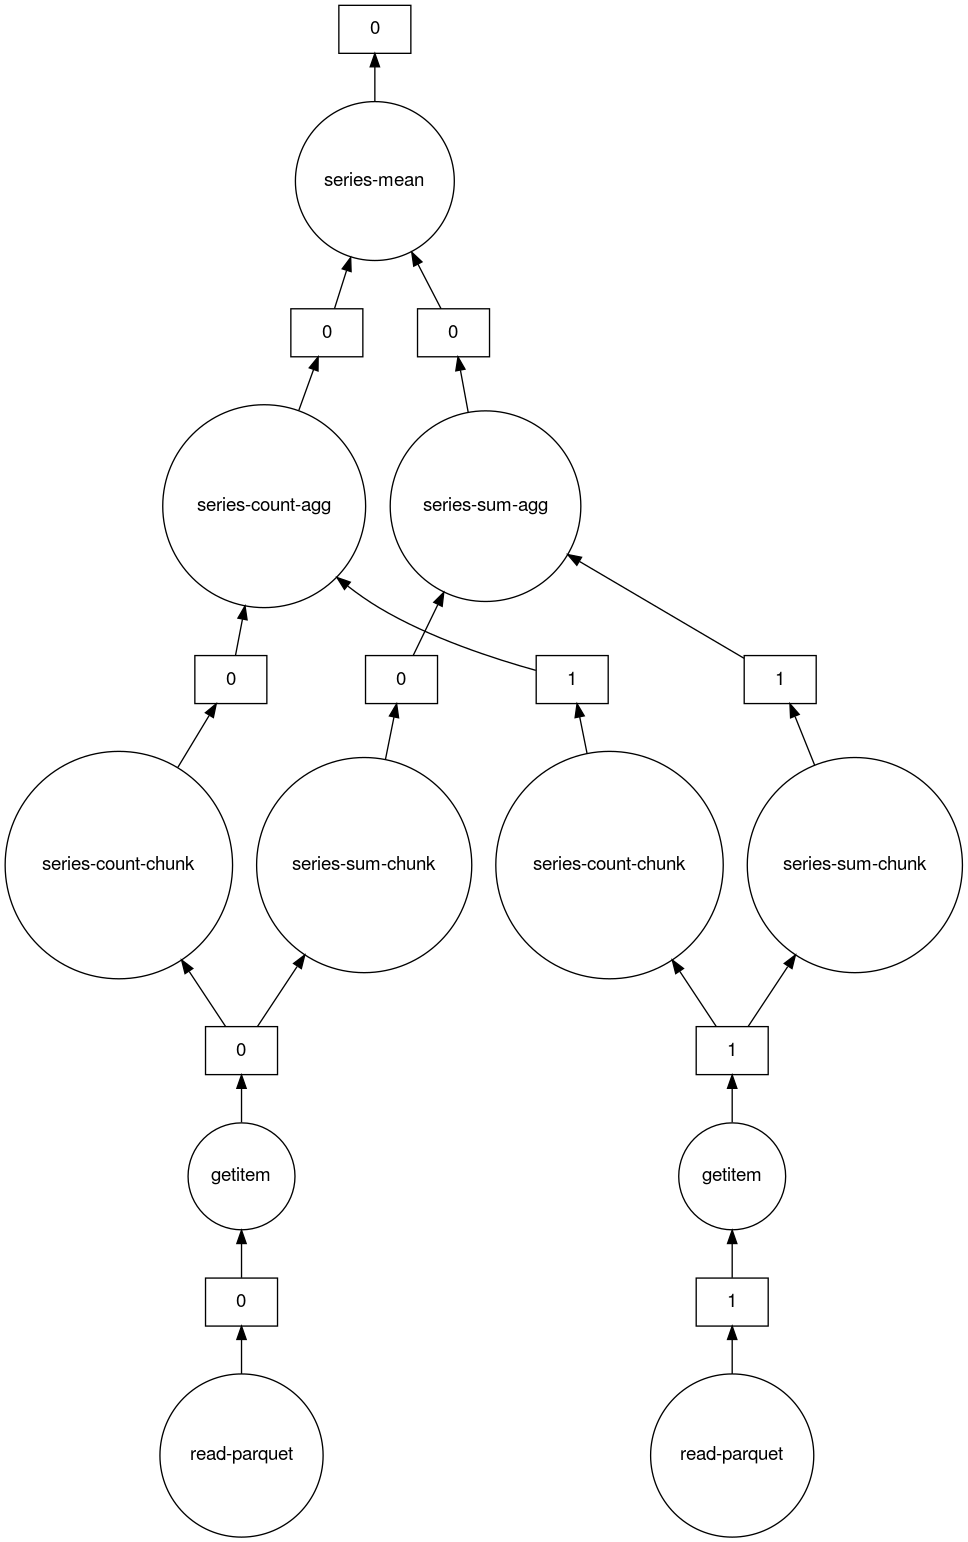

In [ ]:
resposta.visualize()

In [ ]:
%%time
resposta.compute()

CPU times: user 80.2 ms, sys: 79.4 ms, total: 160 ms
Wall time: 6.46 s


0.49997813896442345

Vamos desconectar o cliente solicitando o encerramento do cluster.

In [ ]:
#client.shutdown()

Conclusões anteriores (sem HDFS):
1. Com um worker, ~25s para realizar o procedimento
2. Com dois workers, ~12s para realizar o procedimento

Conclusões agora (com HDFS):
1. Com dois workers, ~6s para realizar o procedimento